## crear Virtual Envirment 
- En esta parte estaremos creando un "*Virtual Environment*". Esto es un laboratorio donde está aislado de cualquier otro programa o versión de Python que podremos tener en nuestro ordenador. 

```sh
conda create --name clase anaconda -y
conda activate clase
pip install -r requirements.txt

```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import wbdata
import pycountry

In [2]:
url = 'https://en.wikipedia.org/wiki/corruption_Perceptions_Index'

html = requests.get(url).content

# Get the 2022-2020 data
df_list = pd.read_html(html,match='2022')
df_2022 = df_list[-1]
df_2022.drop(columns=df_2022.columns[0], axis=1, inplace=True)

# Get the 2019-2010 data
df_list = pd.read_html(html,match='2014')
df_2019 = df_list[-1]
df_2019.drop(columns=df_2019.columns[0], axis=1, inplace=True)

# Get the 2009-2000 data
df_list = pd.read_html(html,match='2009')
df_2009 = df_list[-1]
df_2009.drop(columns=df_2009.columns[0], axis=1, inplace=True)

# Get the 1999-1995 data
df_list = pd.read_html(html,match='1995')
df_1999 = df_list[-1]
df_1999.drop(columns=df_1999.columns[0], axis=1, inplace=True)

In [3]:
# chang column names
df_2022.columns = ['country', 'score 2022','change 2022','score 2021','change 2021','score 2020','change 2020']
df_2022.drop_duplicates(subset='country', keep='first', inplace=True)

df_2019.columns = ['country', 'score 2019','change 2019','score 2018','change 2018','score 2017','change 2017',
                   'score 2016','change 2016','score 2015','change 2015','score 2014','change 2014','score 2013',
                   'change 2013','score 2012','change 2012','score 2011','change 2011','score 2010','change 2010']
df_2019.drop_duplicates(subset='country', keep='first', inplace=True)

df_2009.columns = ['country', 'score 2009','change 2009','score 2008','change 2008','score 2007','change 2007',
                   'score 2006','change 2006','score 2005','change 2005','score 2004','change 2004','score 2003',
                   'change 2003','score 2002','change 2002','score 2001','change 2001','score 2000','change 2000']
df_2009.drop_duplicates(subset='country', keep='first', inplace=True)

df_1999.columns = ['country', 'score 1999','change 1999','score 1998','change 1998','score 1997','change 1997',
                   'score 1996','change 1996','score 1995']
df_1999.drop_duplicates(subset='country', keep='first', inplace=True)

In [4]:
## Merge all dataframes
df = pd.merge(df_2022, df_2019, on='country',)
df = pd.merge(df, df_2009, on='country',)
df = pd.merge(df, df_1999, on='country',)

In [5]:
# Add ISO3 column
for i in range(len(df)):
    try:
        df.loc[i,'ISO3'] = pycountry.countries.search_fuzzy(df.loc[i,'country'])[0].alpha_3
    except:
        df.loc[i,'ISO3'] = np.nan

In [6]:
# Get the World Bank data for population and GDP

country = []
for i in df['ISO3']:
    country.append(str(i))
indicators = {"NY.GDP.PcAP.cD": "GDP per capita (current Us$)", 
              'Gc.DOD.TOTL.GD.Zs': "central government debt, total (% of GDP)", "SP.POP.TOTL": "Population, total"}

for i in range(len(country)):
    if country[i] == 'nan':
        country[i] = 'WLD'

df_wb = wbdata.get_dataframe(indicators, country=country, convert_date=False)
df_wb = df_wb.reset_index()
df_wb = df_wb.rename(columns={'NY.GDP.PcAP.cD': 'GDP per capita (current Us$)', 
                              'Gc.DOD.TOTL.GD.Zs': "central government debt, total (% of GDP)",
                              'SP.POP.TOTL': 'Population, total'})

In [7]:
# drop unneeded years
for i in df_wb['date']:
    if int(i) < 1995:
        df_wb.drop(df_wb[df_wb['date'] == i].index, inplace=True)
df_wb

,country,date,GDP per capita (current Us$),"central government debt, total (% of GDP)","Population, total"
0,Albania,2021,6492.872012,NaN,2811666.0
1,Albania,2020,5332.160475,84.058619,2837849.0
2,Albania,2019,5396.215864,75.698488,2854191.0
3,Albania,2018,5287.663694,64.570326,2866376.0
4,Albania,2017,4531.019374,75.888752,2873457.0
...,...,...,...,...,...
5726,Zimbabwe,1999,585.331799,NaN,11716454.0
5727,Zimbabwe,1998,554.361484,NaN,11548364.0
5728,Zimbabwe,1997,750.683909,NaN,11362401.0
5729,Zimbabwe,1996,765.165124,NaN,11178171.0


In [8]:
# Transpose cpi data
df_cpi = df.melt(id_vars=['country','ISO3'], var_name='date', value_name='CPI')
df_cpi['date'] = df_cpi['date'].str.extract('(\d+)').astype(int)
df_cpi = df_cpi.sort_values(by=['country','date'])
df_cpi = df_cpi.reset_index(drop=True)
df_cpi

,country,ISO3,date,CPI
0,Albania,ALB,1995,—
1,Albania,ALB,1996,—
2,Albania,ALB,1996,—
3,Albania,ALB,1997,—
4,Albania,ALB,1997,—
...,...,...,...,...
5165,Zimbabwe,ZWE,2020,1
5166,Zimbabwe,ZWE,2021,23
5167,Zimbabwe,ZWE,2021,NaN
5168,Zimbabwe,ZWE,2022,23


In [9]:
# turn date into int
df_wb['date'] = df_wb['date'].astype(int)
df_cpi['date'] = df_cpi['date'].astype(int)

In [10]:
# Merge cpi and wb data
df = pd.merge(df_cpi, df_wb, on=['country','date'])

In [11]:
for i in df['CPI']:
    if i == '—':
        df['CPI'].replace(i, np.nan, inplace=True)
df['CPI'] = df['CPI'].astype(float)


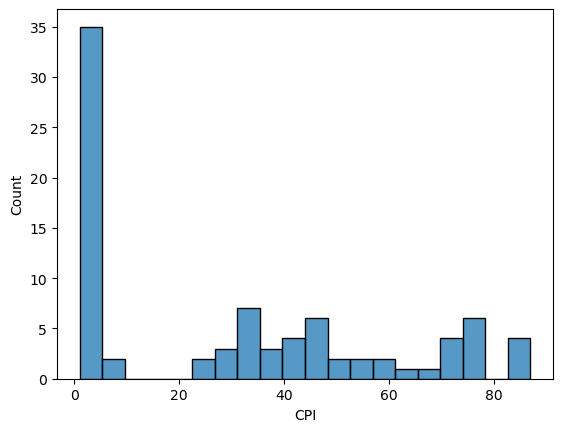

In [12]:
# histogram of CPI after for only 2022
df_2022 = df[df['date'] == 2019]
df_2022 = df_2022.dropna()
df_2022 = df_2022.reset_index(drop=True)
plt = sns.histplot(data=df_2022, x='CPI', bins=20)

In [13]:
# graph spain cpi
df_spain = df[df['country'] == 'Spain']
df_spain = df_spain.sort_values(by='date')
df_spain = df_spain.reset_index(drop=True)